In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit, least_squares, leastsq
import glob
import os
from numpy import exp 
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit, least_squares, leastsq

plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.family'] = "Serif"

# Goals: 
## - Giving code on how to turn spectra into Roman spectra
## - User should give redshift and line fluxes using the methods here

# **Part 1: Fitting an Emission Line**

## Function Definitions 

Function 1: Calculate redshift from velocity
This function calculates the redshift, which measures how much the wavelength of light is stretched due to an object's motion away from the observer.

Inputs:
- vel: The velocity of the object in km/s.

Steps:
   Divide the object's velocity by the speed of light (300,000 km/s) to calculate the redshift:
   redshift = vel / 300,000

Output:
The redshift value, which indicates the fractional increase in wavelength due to the object's motion.

In [6]:
def redshift(vel):
    """
    Calculate redshift based on the velocity of an object.

    Parameters:
    vel (float): Velocity in km/s

    Returns:
    float: Redshift value
    """
    return vel / 300000.0  # Divide velocity by the speed of light (in km/s)

Function 2: Calculate line width (sigma) from velocity dispersion
This function calculates the observed width of a spectral line (sigma) by combining the broadening from the object's velocity dispersion and the instrumental resolution.

Inputs:
- vel_sigma: The velocity dispersion of the object in km/s.
- rest_line: The rest-frame wavelength of the spectral line in Angstroms.
- inst_res_fwhm: The instrument's resolution in Angstroms (FWHM).

Steps:
1. Convert velocity dispersion to wavelength broadening using the formula:
   sigma_object = (vel_sigma / 300,000) * rest_line
   where 300,000 is the speed of light in km/s.

2. Convert the instrument's resolution (FWHM) to sigma using:
   sigma_instrument = inst_res_fwhm / 2.354

3. Combine the intrinsic and instrumental broadening using:
   total_sigma = sqrt(sigma_object^2 + sigma_instrument^2)

Output:
The total line width (sigma) in Angstroms, accounting for both effects.

In [9]:
def line_width(vel_sigma, rest_line, inst_res_fwhm):
    """
    Calculate the total line width (sigma), accounting for both intrinsic width and instrument resolution.

    Parameters:
    vel_sigma (float): Velocity dispersion in km/s
    rest_line (float): Rest-frame wavelength of the emission line (in Angstroms)
    inst_res_fwhm (float): Instrument resolution (Full Width at Half Maximum)

    Returns:
    float: Total line width (sigma) in Angstroms
    """
    sigma = vel_sigma / (300000.0 - vel_sigma) * rest_line  # Convert velocity dispersion to wavelength dispersion
    return np.sqrt(sigma**2 + (inst_res_fwhm / 2.354)**2)  # Combine intrinsic and instrument effects

Function 3: Generate a Gaussian profile
This function creates a Gaussian profile to model an emission or absorption line in a spectrum. It accounts for the line's peak intensity, position, width, and instrumental effects.

1. The input `wave` is the array of wavelengths where the profile will be evaluated.
2. The `amplitude` specifies the height of the Gaussian peak, representing the line's intensity.
3. The `vel` shifts the line's rest wavelength (`rest_wave`) to account for Doppler effects, using the `redshift` function.
4. The `vel_sigma` represents the velocity dispersion of the source, which determines the line's width in combination with the instrumental resolution (`inst_res_fwhm`).
5. The formula `exp(-(wave - redshifted_wave)**2 / (2 * sigma**2))` generates a symmetric Gaussian curve centered on the Doppler-shifted wavelength with a width (`sigma`) calculated by `line_width`.

The output is a Gaussian profile as an array, describing how the line's intensity varies with wavelength.

In [12]:
def gauss(wave, amplitude, vel, vel_sigma, rest_wave, inst_res_fwhm):
    """
    Generate a Gaussian line profile based on input parameters.

    Parameters:
    wave (array): Wavelength array (in Angstroms)
    amplitude (float): Peak intensity of the line
    vel (float): Velocity shift in km/s
    vel_sigma (float): Velocity dispersion in km/s
    rest_wave (float): Rest-frame wavelength of the line (in Angstroms)
    inst_res_fwhm (float): Instrument resolution (FWHM in Angstroms)

    Returns:
    array: Gaussian line profile
    """
    redshifted_wave = rest_wave * (1 + redshift(vel))  # Shift rest wavelength by velocity
    sigma = line_width(vel_sigma, rest_wave, inst_res_fwhm)  # Calculate line width (sigma)
    return amplitude * exp(-(wave - redshifted_wave)**2 / (2 * sigma**2))


Function 4: This function models the H-alpha (6562.819 Å) emission line in a spectrum. It assumes core Gaussian components dominate while wing components are zero.

1. `Ha_core`: Models the H-alpha emission line core using a Gaussian centered at 6562.819 Å, with amplitude `amp_Ha_core` and velocity-related adjustments (`vel_core`, `vel_sigma_core`).

2. `cont`: Models the linear continuum background as `(wave/1000) * m + c`, where `m` is the slope and `c` is the intercept.

The function returns the sum of the modeled H-alpha and the continuum.

In [15]:
c = 300000
def Ha_model_single(wave, amp_Ha_core, vel_core, vel_sigma_core, m, c):
    """
    Model H-alpha lines with Gaussian profiles, including a continuum.

    Parameters:
    wave (array): Wavelength array (in Angstroms)
    amp_Hb_core (float): Amplitude of the core component of H-beta
    vel_core (float): Velocity shift for core components (in km/s)
    vel_sigma_core (float): Velocity dispersion for core components (in km/s)
    m (float): Slope of the linear continuum
    c (float): Intercept of the linear continuum

    Returns:
    array: Combined model of H-alpha, and the continuum
    """
    Ha_core = gauss(wave, amp_Ha_core, vel_core, vel_sigma_core, 6562.819, 2.3)  # H-alpha core
    cont = (wave / 1000) * m + c  # Linear continuum
    return Ha_core + cont

Function 5: Model H-alpha and NII lines with single Gaussians
This function models the H-alpha (6562.8 Å) and NII (6548 Å, 6583 Å) emission lines using Gaussian profiles. It assumes each line has a single Gaussian core component:

1. H-alpha Core: Modeled using a Gaussian centered at the H-alpha rest wavelength, adjusted for velocity (`vel_core`) and width (`vel_sigma_core`).
2. NII Core Components:
   - NII 6548 Å: Its amplitude is scaled by `1/2.61` relative to the NII 6583 Å line.
   - NII 6583 Å: Modeled as a Gaussian using the provided parameters.
3. Linear Continuum: A simple straight line is added to represent background continuum emission using the slope (`m`) and intercept (`c`).

The function outputs the sum of these components, providing a combined model for H-alpha, NII, and the continuum.

In [18]:
 def Ha_NII_gauss_model_single(wave, amp_Ha_core, amp_NII_core, vel_core, vel_sigma_core, m, c):
    """
    Model H-alpha and NII lines with Gaussian profiles, including a continuum.

    Parameters:
    wave (array): Wavelength array (in Angstroms)
    amp_Hb_core (float): Amplitude of the core component of H-beta
    amp_OIII_core (float): Amplitude of the core component of OIII
    vel_core (float): Velocity shift for core components (in km/s)
    vel_sigma_core (float): Velocity dispersion for core components (in km/s)
    m (float): Slope of the linear continuum
    c (float): Intercept of the linear continuum

    Returns:
    array: Combined model of H-alpha NII, and the continuum
    """
    Ha_core = gauss(wave, amp_Ha_core, vel_core, vel_sigma_core, 6562.819, 2.3)  # H-alpha core
    NII_core_6548 = gauss(wave, amp_NII_core, vel_core, vel_sigma_core, 5006.8, 2.3)  # NII core at 6548
    NII_core_6583 = 0.33 * gauss(wave, amp_NII_core, vel_core, vel_sigma_core, 4959, 2.3)  # NII core at 6583
    cont = (wave / 1000) * m + c  # Linear continuum
    return Ha_core + NII_core_6548 + NII_core_6583 + Ha_wing + NII_core_6583 + NII_wing_5007 + cont


# Fitting an Emission Line

### Step 1: Load and read a spectra file (duh)

In [21]:
data=np.loadtxt('//Users/slkumar/Downloads/J132152+472746.txt')
ivar=data.T[2]

The `np.loadtxt()` function reads the file containing the spectrum data.

The file contains columns for flux, log_wavelength, and inverse variance.

The data is stored as a 2D array where each row corresponds to a single data point.


In [24]:
flux=data.T[0]

data.T transposes the array, swapping rows and columns.

The first column (index 0) corresponds to the flux values, which measure the brightness at each wavelength.

This is extracted and stored in the variable flux.

In [27]:
log_lam=data.T[1]

Extract logarithmic wavelength:

The second column (index 1) contains the logarithm (base 10) of the wavelength values.

These logarithmic values are stored in log_lam.

In [30]:
wav=10**log_lam

The logarithmic wavelength values are exponentiated (base 10) to get the actual wavelength (wav) in microns or another unit.

The resulting array represents the wavelengths in physical space.

In [33]:
z=1.8
wav=wav*(1+z)

With Roman, we will likely looking into the high redshift universe.
It is like JWST. Which means all these galaxies would be be redshifted away from us.
So, let's just start with a galaxy at the cosmic high noon. That is between redshift 1 and 3.
This is when multiple galaxies start merging and triggering an astounding star formation rate increase.

For, now we assume a galaxy with redshift z=1.8,
Which means that the wavelength will appear longer. 
It is because their rest-frame wavelength is multiplied by a factor (1+redshift)

In [36]:
ivar = data.T[2]

The third column (index 2) contains the inverse variance (1 / noise²), representing the data's uncertainty.

Notes on redshifting and de-redshifting:

The wavelengths in the file are redshifted due to the motion of the object.

The observable range is between 1 and 1.93 microns.

After extracting the data, the redshift can be used to "de-redshift" the wavelengths, restoring them to their original rest-frame values.

This process extracts the key components—flux, wavelength, and uncertainty—from the spectrum data for further analysis.

## Step 2 - Look at the spectrum to identify emission lines

In [40]:
#de-redshifting and redshifting spectra 
# Step 1: Read the SDSS spectrum
data = np.loadtxt('/Users/slkumar/Downloads/J132152+472746.txt')
flux = data.T[0]*1e-17  # Flux
log_lam = data.T[1]  # Logarithmic wavelength
ivar = data.T[2]  # Inverse variance (1 / noise^2)
wav = 10**log_lam  # Convert log wavelength to linear wavelength

#source's redshift z=0.015
rest_wav=wav/(1.015)
rest_flux=flux*(1.015)

# Step 1.25: Redshift the spectrum
z = 1.8  # Example redshift
obs_wav = rest_wav * (1 + z)
obs_flux = rest_flux / (1 + z)

# Step 1.5: Resample to obtain a constant delta lambda
resampled_wav = np.arange(obs_wav.min(), obs_wav.max(), 1)  # Roman's wavelength grid
resampled_flux = np.interp(resampled_wav, obs_wav, obs_flux)

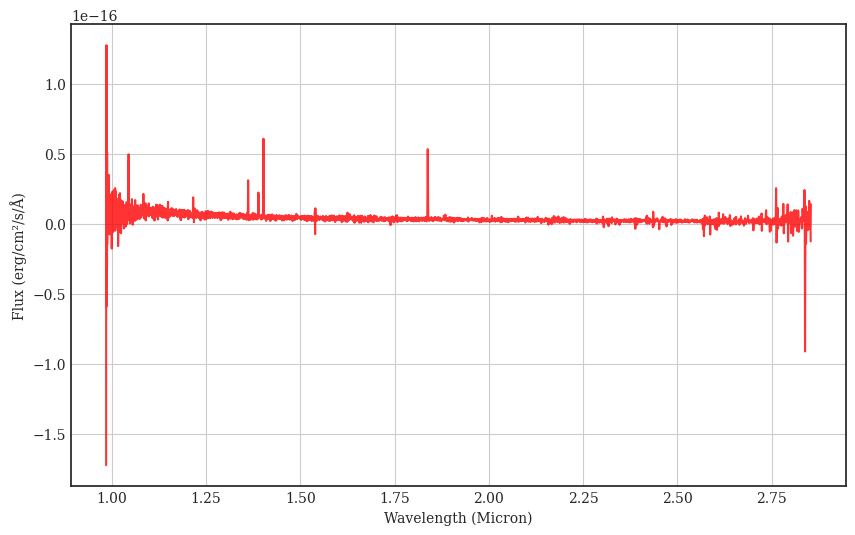

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(resampled_wav/1e4, resampled_flux, color='red', alpha=0.8)
plt.xlabel('Wavelength (Micron)')
plt.ylabel('Flux (erg/cm²/s/Å)')
plt.grid()
plt.show()

This process extracts a spectum with many peak likefeatures visible. 
Those are the emission lines.


1. Galaxies:
   - Star-forming regions: Young stars ionize hydrogen gas, producing emission lines like H-alpha (6563 Å) and H-beta (4861 Å). Metal lines, like [O III] 5007 Å and [N II] 6584 Å, arise from ionized gas.

2. Active Galactic Nuclei (AGN):
   - Broad lines: High-velocity gas near the black hole produces Doppler-broadened lines like H-alpha and H-beta.
   - Narrow lines: Ionized gas in outer regions forms narrow lines like [O III] 5007 Å.
   - Highly ionized lines: X-rays create lines from elements like neon and iron.

3. Stars:
   - Hot stars: Produce hydrogen and helium emission lines.
   - Cool stars: Show molecular and metal emission lines due to lower temperatures.

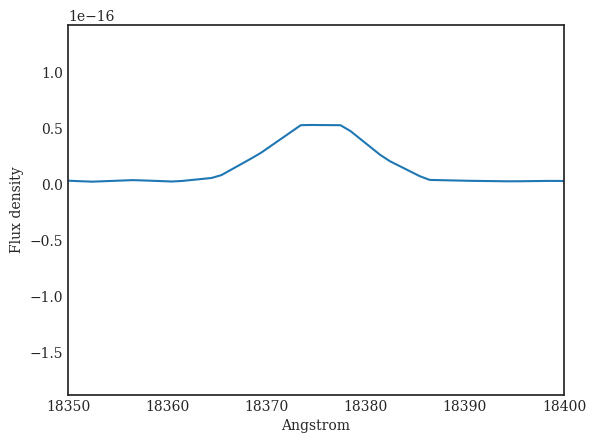

In [45]:
plt.figure()
plt.plot(resampled_wav, resampled_flux)
plt.xlim(18350, 18400)
plt.xlabel('Angstrom')
plt.ylabel('Flux density')
plt.show()

Now, it's time to zoom in on the emission lines. We see a strong single emission line around 18000 Angstroms, so let's focus on that.

plt.plot(wav, flux): Plots the flux (intensity) against the wavelength (in Angstroms).
    
plt.xlim(18630, 18675): Sets the x-axis limits to zoom in on the region between 6640 and 6680 Angstroms.
    
plt.xlabel('Angstrom'): Labels the x-axis as "Angstrom" to indicate the wavelength unit.
    
plt.ylabel('Flux density'): Labels the y-axis as "Flux density" to indicate the intensity unit.
 



The single emission line could be indicative of H-$\alpha$ whose restframe wavelength is 6562.819

Since, we already know its rest-frame wavelength this gives us a great chance to directly measure its redshift.

## Step 3 - Estimate Redshift

1. The observed peak is estimated to be between 6655 Å and 6665 Å, so we assume it is around 6660 Å.
2. Redshift is calculated using the formula:
   z = (observed wavelength - rest wavelength) / rest wavelength.
3. The rest wavelength for the emission line must be known, for example, 4861 Å for [H $\alpha$].
4. Using the assumed observed wavelength and the rest wavelength, calculate the redshift.
5. If the redshift estimate is inconsistent with expectations, refine the observed wavelength guess or verify the line identification.

In [51]:
# Here we estimate a best guess for the redshift

Observed_wavelength = 18375
Restframe_wavelength = 6562.819

Redshift= (Observed_wavelength-Restframe_wavelength)/Restframe_wavelength

print(Redshift)

1.799863899949092


In [53]:
c=300000 #This sets the speed of light, which is a key value used to calculate redshift-related velocities.
k=1+Redshift # 
deredshifted_wav=resampled_wav/k

Redshift represents the redshift value (z) of the source.
The redshift factor k is calculated as 
k=1+z, which scales rest-frame wavelengths to observed wavelengths.

## Step 4 - Mask data to include emission line

In [57]:
select_Ha = (deredshifted_wav>6450)&(deredshifted_wav<6650) 

This step creates a boolean mask (select_Ha) that identifies the wavelengths corresponding to the redshifted H-alpha line, assuming it falls between 6450 Å and 6650 Å after scaling by the redshift factor k.


In [60]:
wav_Ha = deredshifted_wav[select_Ha]
flux_Ha =resampled_flux[select_Ha]

wav_Hb extracts the observed wavelengths from the wav array that fall within the selected range.

flux_Hb extracts the corresponding flux values from the flux array

## Step 5 - use `curve_fit` to fit the emission line

In [64]:
popt_Ha,pcov_Ha=curve_fit(Ha_model_single,wav_Ha,flux_Ha,p0=[5,100,60,0.1,0.001],maxfev=10000000)
print(popt_Ha)

[ 5.26292678e-17  5.99558690e+00  6.51454849e+01  8.66384685e-19
 -2.64084553e-18]


curve_fit fits the Ha_model_single function (assumed to be predefined) to the extracted wavelength (wav_Ha) and flux (flux_Ha) data.

The p0 parameter provides initial guesses for the model parameters:
    
5: Initial guess for the amplitude of the H-beta line.
    
c * Redshift: Initial guess for the velocity of the line, calculated from the redshift.
    
60: Initial guess for the velocity dispersion (line width) in km/s.
    
0.1: Initial guess for a linear continuum slope.
    
0.001: Initial guess for the linear continuum intercept.
    
maxfev=10000000 ensures the fitting algorithm performs enough iterations to converge.

The variable popt_Ha[1] contains the velocity of the H-beta emission line in kilometers per second (km/s), as determined from the fit.

In [67]:
fitted_model=Ha_model_single(wav_Ha,popt_Ha[0],popt_Ha[1],popt_Ha[2],popt_Ha[3],popt_Ha[4])

Ha_model_single is the predefined function modeling the H-$\alpha$ emission line.

The function is called with the selected wavelength values (wav_Hb) and the optimized parameters (popt_Ha) from the curve fit:
    
popt_Hb[0]: Amplitude of the H-$\alpha$ line.
    
popt_Hb[1]: Velocity shift (km/s).
    
popt_Hb[2]: Velocity dispersion (km/s).
    
popt_Hb[3]: Linear continuum slope.
    
popt_Hb[4]: Linear continuum intercept.
    
The result, fitted_model, is the Gaussian model evaluated at the wavelengths wav_Hb using the best-fit parameters.

## Step 6 - Plot! 

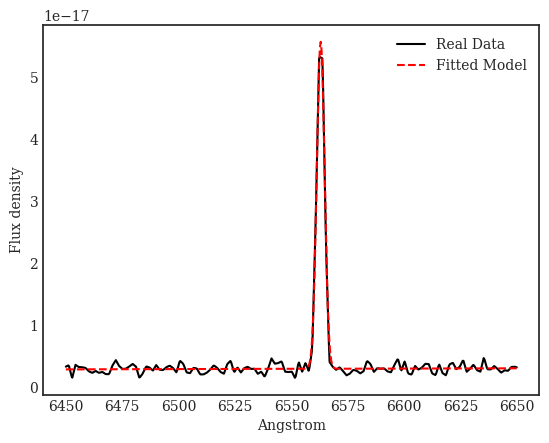

In [71]:
plt.figure()
plt.plot(wav_Ha,flux_Ha,'k-', label = 'Real Data')
plt.plot(wav_Ha,fitted_model,'r--', label = 'Fitted Model')
plt.legend()
plt.xlabel('Angstrom')
plt.ylabel('Flux density')
plt.show()

# **Part 2: Simulating Roman Spectra & Fitting an Emission Line**

In [74]:
#de-redshifting and redshifting spectra 
# Step 1: Read the SDSS spectrum
data = np.loadtxt('/Users/slkumar/Downloads/J132152+472746.txt')
flux = data.T[0]*1e-17  # Flux
log_lam = data.T[1]  # Logarithmic wavelength
ivar = data.T[2]  # Inverse variance (1 / noise^2)
wav = 10**log_lam  # Convert log wavelength to linear wavelength

#source's redshift z=0.015
rest_wav=wav/(1.015)
rest_flux=flux*(1.015)

# Step 1.25: Redshift the spectrum
z = 1.8  # Example redshift
obs_wav = rest_wav * (1 + z)
obs_flux = rest_flux / (1 + z)

# Step 1.5: Resample to obtain a constant delta lambda
resampled_wav = np.arange(obs_wav.min(), obs_wav.max(), 1)  # Roman's wavelength grid
resampled_flux = np.interp(resampled_wav, obs_wav, obs_flux)

## Turning Spectra into Roman 

In [77]:
#Function to create Roman spectra from inputted spectra 
def roman_resolution(wavelength, flux): 
    # step 1: Smooth spectrum by source's spatial extent (0.11"/pix)
    #fwhm = full with half-max, how wide the gaussian is 
    size_fwhm_arcsec=1.5 
    size_sigma_pixel=size_fwhm_arcsec / 2.354 / .11 * 11 #sigma and fwhm are related by the factor of 2.354, converting arcsec to pixels 
    smoothed_flux = gaussian_filter1d(flux, size_sigma_pixel) #smooth out flux 
    
    # Step 2: Smooth the spectrum with the Line Spread Function
    fwhm = 20  # FWHM in Angstroms
    sigma = fwhm / 2.354  # Convert FWHM to sigma
    smoothed_flux2 = gaussian_filter1d(smoothed_flux, sigma/np.mean(np.diff(resampled_wav)))
    
    # Step 3: Resample onto a grid with 11 Angstrom sampling
    new_wav = np.arange(wavelength.min(), wavelength.max(), 11)  # Roman's wavelength grid
    new_flux = np.interp(new_wav, wavelength, smoothed_flux2)
    
    return new_wav, new_flux

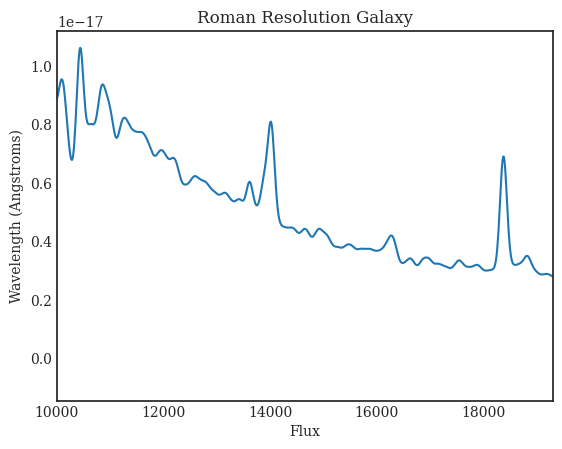

In [79]:
#putting our wavelength and flux through the roman_resolution function
roman_wav, roman_flux = roman_resolution(resampled_wav, resampled_flux)

#plotting 
plt.figure()
plt.plot(roman_wav, roman_flux)
plt.xlim(10**4, 1.93*10**4)
plt.xlabel('Flux')
plt.ylabel('Wavelength (Angstroms)')
plt.title('Roman Resolution Galaxy')
plt.show()

## Fitting H-$\alpha$ line to Roman Spectra 

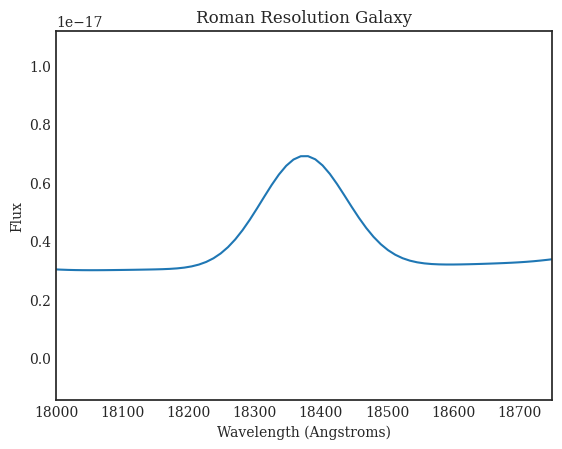

The peak is at  18699.462049199487


In [82]:
#isolate H-α line
plt.figure()
plt.plot(roman_wav, roman_flux)
plt.ylabel('Flux')
plt.xlabel('Wavelength (Angstroms)')
plt.title('Roman Resolution Galaxy')
plt.xlim(18000, 18750)
plt.show()

H_alpha_obs = max(roman_wav[np.where((roman_wav > 18000) & (roman_wav < 18700))])
print("The peak is at ", H_alpha_obs)

## Fitting an Emission Line 

### The steps are the exact same as before!

### Estimate Redshift 

In [85]:
H_alpha_rest = 6562.819
Redshift = (H_alpha_obs - H_alpha_rest)/H_alpha_rest
print("The redshift is", Redshift)

The redshift is 1.8493033327902972


### De-Redshift Spectra

In [88]:
#de-redshift the data by calculating k factor
k = 1 + Redshift  
deredshifted_wav = roman_wav / k

### Mask data to only include H-alpha

In [91]:
select_H_alpha = (deredshifted_wav>6350)&(deredshifted_wav<6550) 
wav_Ha = deredshifted_wav[select_H_alpha]
flux_Ha = roman_flux[select_H_alpha]

### Use `curve_fit` and `Ha_model_single`

In [94]:
c = 300000
popt_Ha,pcov_Ha=curve_fit(Ha_model_single,wav_Ha,flux_Ha,p0=[0.1,100,6000,0.1,0.001],maxfev=10000000)

fitted_model=Ha_model_single(wav_Ha,popt_Ha[0],popt_Ha[1],popt_Ha[2],popt_Ha[3],popt_Ha[4])

### Plot

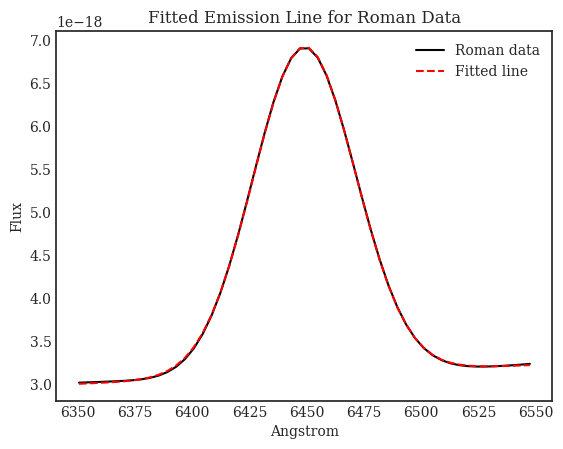

In [97]:
plt.figure()
plt.plot(wav_Ha,flux_Ha,'k-', label = 'Roman data')
plt.plot(wav_Ha,fitted_model,'r--', label = 'Fitted line')
plt.legend()
plt.title('Fitted Emission Line for Roman Data')
plt.xlabel('Angstrom')
plt.ylabel('Flux')
plt.show()

# Exercise - Try it on your own! 

### Try degrading and fitting an emission line to one of the galaxy spectra located in the `spectra/galaxy` folder in the GitHub 

**Challenge**: Fit H-$\alpha$ and NII lines together using the `Ha_NII_gauss_model_single` function defined earlier

In [140]:
#load in spectra 

#put it to Roman resolution 

#fit emission line